In [1]:
from ConvergenceAnalysis import *
from DataAnalysisClass import *

In [2]:

single = ['aug-cc-pVDZ', 'aug-cc-pVTZ', 'aug-cc-pVQZ', 'aug-cc-pV5Z', 'aug-cc-pV6Z']
single_polarized = ['aug-cc-pCVDZ', 'aug-cc-pCVTZ', 'aug-cc-pCVQZ']
double = ['d-aug-cc-pVDZ', 'd-aug-cc-pVTZ', 'd-aug-cc-pVQZ', 'd-aug-cc-pV5Z', 'd-aug-cc-pV6Z']
double_polarized = ['d-aug-cc-pCVDZ', 'd-aug-cc-pCVTZ', 'd-aug-cc-pCVQZ']
all_basis_sets = single + single_polarized + double + double_polarized


In [3]:

pal2 = sns.color_palette("coolwarm_r", 4).as_hex()
p2 = [pal2[1], pal2[0], pal2[2], pal2[3]]
pal = sns.color_palette(p2)
p1 = [pal2[1], pal2[2], pal2[0], pal2[3]]
simple_pal = sns.color_palette(p1)




In [4]:

database_path = Path('/mnt/data/madness_data/post_watoc/august')
paper_path = Path('/home/adrianhurtado/projects/writing/mra-tdhf-polarizability/Figures_v2')



In [5]:
import glob

# glob for .mol files in august molecules directory
mols = glob.glob('/mnt/data/madness_data/post_watoc/august/molecules/*.mol')
mols = [mol.split('/')[-1].split('.')[0] for mol in mols]

In [6]:
august_database = PolarizabilityData(mols, 'hf', 'dipole', all_basis_sets, database_path,
                                     overwrite=False)


In [7]:
august_database.save_dfs()
polar_data = august_database.iso_data.copy()



In [8]:
class MRAComparedBasisDF(pd.DataFrame):
    def __init__(self, polar_data, index, values: list, PercentError: bool, *args, **kwargs):
        # Use the special_parameter to modify the DataFrame or perform additional initialization
        basis_data = polar_data.query('basis!="MRA"').copy()
        basis_data = basis_data.set_index(index)

        for value in values:
            basis_data[f'{value}MRA'] = polar_data.query('basis=="MRA"').set_index(index)[
                value]
            if PercentError:
                basis_data[f'{value}E'] = ((basis_data[value] - basis_data[f'{value}MRA']) / basis_data[f'{value}MRA'] * 100)
            else:
                basis_data[f'{value}E'] = (basis_data[value] - basis_data[f'{value}MRA'])
        basis_data = basis_data.reset_index()
        # create a column of percent error in alpha
        basis_data = make_detailed_df(basis_data)
        super().__init__(basis_data, *args, **kwargs)


basis_data = MRAComparedBasisDF(polar_data, ['molecule', 'omega'], ['alpha', 'gamma'], True)
basis_data


['D', 'T', 'Q', '5', '6']


,molecule,omega,basis,alpha,gamma,alphaMRA,alphaE,gammaMRA,gammaE,augmentation,polarization,mol_system,valence,Type
0,FNO,0,aug-cc-pVDZ,15.524175,12.210672,16.061667,-3.346423,11.954531,2.142629,aug,V,Fluorine,D,aug-cc-pVnZ
1,FNO,1,aug-cc-pVDZ,15.528797,12.217014,16.066350,-3.345833,11.961972,2.132109,aug,V,Fluorine,D,aug-cc-pVnZ
2,FNO,2,aug-cc-pVDZ,15.542704,12.236058,16.080610,-3.345062,11.980014,2.137261,aug,V,Fluorine,D,aug-cc-pVnZ
3,FNO,3,aug-cc-pVDZ,15.566027,12.267860,16.104437,-3.343241,12.011002,2.138519,aug,V,Fluorine,D,aug-cc-pVnZ
4,FNO,4,aug-cc-pVDZ,15.598992,12.312496,16.138950,-3.345681,12.054358,2.141456,aug,V,Fluorine,D,aug-cc-pVnZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12955,LiBH4,4,d-aug-cc-pV6Z,NaN,NaN,29.055577,NaN,1.921280,NaN,d-aug,V,First-row,6,d-aug-cc-pVnZ
12956,LiBH4,5,d-aug-cc-pV6Z,NaN,NaN,29.473837,NaN,1.939775,NaN,d-aug,V,First-row,6,d-aug-cc-pVnZ
12957,LiBH4,6,d-aug-cc-pV6Z,NaN,NaN,30.010817,NaN,1.957565,NaN,d-aug,V,First-row,6,d-aug-cc-pVnZ
12958,LiBH4,7,d-aug-cc-pV6Z,NaN,NaN,30.681147,NaN,1.975595,NaN,d-aug,V,First-row,6,d-aug-cc-pVnZ


D
T
Q
5


/tmp/ipykernel_10929/2769906853.py:34: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(y=.02, linestyle='--', color='orange')
/tmp/ipykernel_10929/2769906853.py:35: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(y=-.02, linestyle='--', color='orange')


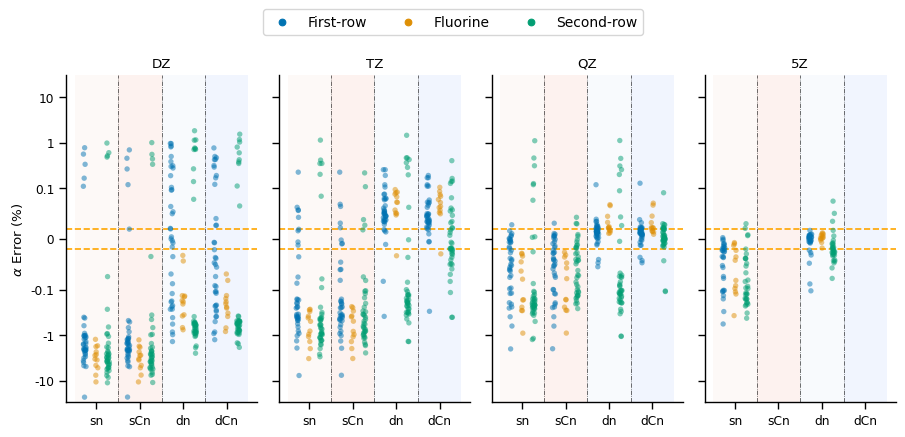

In [10]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

Type_map = {"aug-cc-pVnZ": "sn", "aug-cc-pCVnZ": "sCn", "d-aug-cc-pVnZ": "dn",
            "d-aug-cc-pCVnZ": "dCn"}
aspect_ratio = .5
vlevel = ['D', 'T', 'Q', '5']
plot_data = basis_data.query('valence.isin(@vlevel) and omega==0').copy()
# remove unused categories from valence
plot_data.valence = plot_data.valence.cat.remove_unused_categories()
with sns.plotting_context('paper', font_scale=1.00):
    g = sns.catplot(col='valence', x='Type', y='alphaE', hue='mol_system',
                    data=plot_data, kind='strip', dodge=True, jitter=True,
                    s=15, palette='colorblind', height=4, aspect=aspect_ratio, sharey=True,
                    alpha=0.5,
                    sharex=False)
    # adjust the title to read D=$\zeta$D, T=$\zeta$T, etc.
    g.set_titles('{col_name}Z')
    g.set_xlabels('')

    g.set_xticklabels([Type_map[label.get_text()] for label in g.axes.flat[0].get_xticklabels()])
    v = 0
    for ax in g.axes.flat:
        # draw horizontal line at .05%
        # get the valence level from the title
        c = vlevel[v]
        v += 1
        print(c)
        xl = ['aug', 'aug+core', 'd-aug', 'd-aug+core']
        xl = ['s-n', 's-Cn', 'd-n', 'd-Cn']
        xl = ['sn', 'sCn', 'dn', 'dCn']
        ax.set_xticklabels(xl)

        ax.set_yscale('symlog', linthresh=1e-1)
        ax.axhline(y=.02, linestyle='--', color='orange')
        ax.axhline(y=-.02, linestyle='--', color='orange')
        # for the symlog scale to regular notation with no decimal places for the y axis
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.yaxis.set_major_formatter(FormatStrFormatter('%2g'))

        # make the y limits symmetrical for each plot using the max absolute value
        max_lim = max(abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))
        ax.set_ylim(-30, 30)

        ax.set_ylabel(r'$\alpha$ Error (%)')
        # rotate the xlabels
        for label in ax.get_xticklabels():
            label.set_rotation(0)
            #label.set_horizontalalignment('right')
        # create vertical lines to separate basis sets
        for i in range(1, len(plot_data.Type.unique())):
            ax.axvline(i - .5, linestyle='-.', color='k', linewidth=.5, alpha=.8)
        for i in range(1, 5):
            ax.axvspan((i - 1) - .5, i - .5, 1e-3, facecolor=pal[i - 1], alpha=0.1)

        # remove the legend title

# remove legend and create a new legend in 3 column format outside the plot
g._legend.remove()
g.fig.legend(loc='center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, fontsize=10)
g.fig.tight_layout()

g.fig.savefig(paper_path.joinpath('alpha_error.png'), dpi=600, bbox_inches='tight')

/tmp/ipykernel_10929/2386316885.py:17: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(y=.02, linestyle='--', color='orange')
/tmp/ipykernel_10929/2386316885.py:18: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(y=-.02, linestyle='--', color='orange')
/tmp/ipykernel_10929/2386316885.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xl)


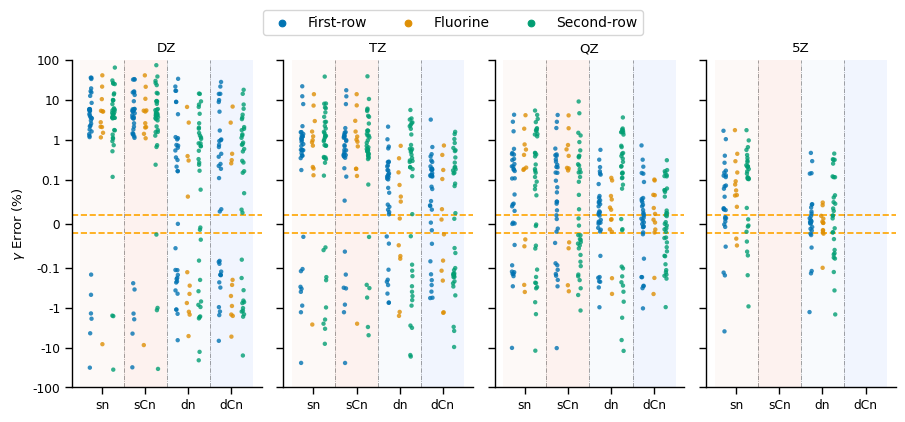

In [11]:

vlevel = ['D', 'T', 'Q', '5']
plot_data = basis_data.query('valence.isin(@vlevel) and omega==0 & gamma > 1e-3').copy()
# remove unused categories from valence
plot_data.valence = plot_data.valence.cat.remove_unused_categories()
with sns.plotting_context('paper', font_scale=1.00):
    g = sns.catplot(col='valence', x='Type', y='gammaE', hue='mol_system',
                    data=plot_data, kind='strip', dodge=True,
                    s=10, palette='colorblind', height=4, aspect=aspect_ratio, sharey=True,
                    alpha=0.8)
    # adjust the title to read D=$\zeta$D, T=$\zeta$T, etc.
    g.set_titles('{col_name}Z')

    g.set_xlabels('')
    for ax in g.axes.flat:
        # draw horizontal line at .05%
        ax.set_yscale('symlog', linthresh=1e-1)
        ax.axhline(y=.02, linestyle='--', color='orange')
        ax.axhline(y=-.02, linestyle='--', color='orange')
        # for the symlog scale to regular notation with no decimal places for the y axis
        xl = ['sn', 'sCn', 'dn', 'dCn']
        ax.set_xticklabels(xl)

        # make the y limits symmetrical for each plot using the max absolute value
        max_lim = max(abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))
        ax.set_ylim(-100, 100)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%2g'))

        ax.set_ylabel(r'$\gamma$ Error (%)')
        # rotate the xlabels
        # create vertical lines to separate basis sets
        for i in range(1, len(plot_data.Type.unique())):
            ax.axvline(i - .5, linestyle='-.', color='k', linewidth=.5, alpha=.5)
        for i in range(1, 5):
            ax.axvspan((i - 1) - .5, i - .5, 1e-3, facecolor=pal[i - 1], alpha=0.1)

        # remove the legend title

g.fig.tight_layout()
# remove legend and create a new legend in 3 column format outside the plot
g._legend.remove()
g.fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.06), ncol=3, fancybox=True, fontsize=10)

g.fig.savefig(paper_path.joinpath('gamma_error.png'), dpi=600, bbox_inches='tight')


In [57]:
plot_data.query('valence=="Q"').sort_values('gammaE', ascending=False).head(10)

,molecule,omega,basis,alpha,gamma,alphaMRA,gammaMRA,alphaE,gammaE,augmentation,polarization,mol_system,valence,Type
11286,SH2,0,aug-cc-pCVQZ,23.839711,0.411159,23.872550,0.376379,-0.137559,9.240760,aug,CV,Second-row,Q,aug-cc-pCVnZ
6210,LiCl,0,aug-cc-pVQZ,23.960626,0.800745,24.028807,0.759215,-0.283745,5.470176,aug,V,Second-row,Q,aug-cc-pVnZ
6246,LiCl,0,aug-cc-pCVQZ,24.000478,0.794723,24.028807,0.759215,-0.117896,4.676977,aug,CV,Second-row,Q,aug-cc-pCVnZ
9234,H2O,0,aug-cc-pVQZ,8.508389,1.162395,8.542136,1.114567,-0.395071,4.291153,aug,V,First-row,Q,aug-cc-pVnZ
12258,NaH,0,aug-cc-pVQZ,34.400229,6.818011,34.025267,6.540320,1.102012,4.245825,aug,V,Second-row,Q,aug-cc-pVnZ
9270,H2O,0,aug-cc-pCVQZ,8.508365,1.161738,8.542136,1.114567,-0.395348,4.232168,aug,CV,First-row,Q,aug-cc-pCVnZ
2466,HF,0,aug-cc-pVQZ,4.864793,1.317861,4.909196,1.265038,-0.904484,4.175644,aug,V,Fluorine,Q,aug-cc-pVnZ
2502,HF,0,aug-cc-pCVQZ,4.864931,1.317298,4.909196,1.265038,-0.901665,4.131121,aug,CV,Fluorine,Q,aug-cc-pCVnZ
12321,NaH,0,d-aug-cc-pVQZ,34.404377,6.780170,34.025267,6.540320,1.114202,3.667251,d-aug,V,Second-row,Q,d-aug-cc-pVnZ
3042,SF2,0,aug-cc-pVQZ,21.958125,3.299353,22.027333,3.191921,-0.314191,3.365772,aug,V,Second-row,Q,aug-cc-pVnZ


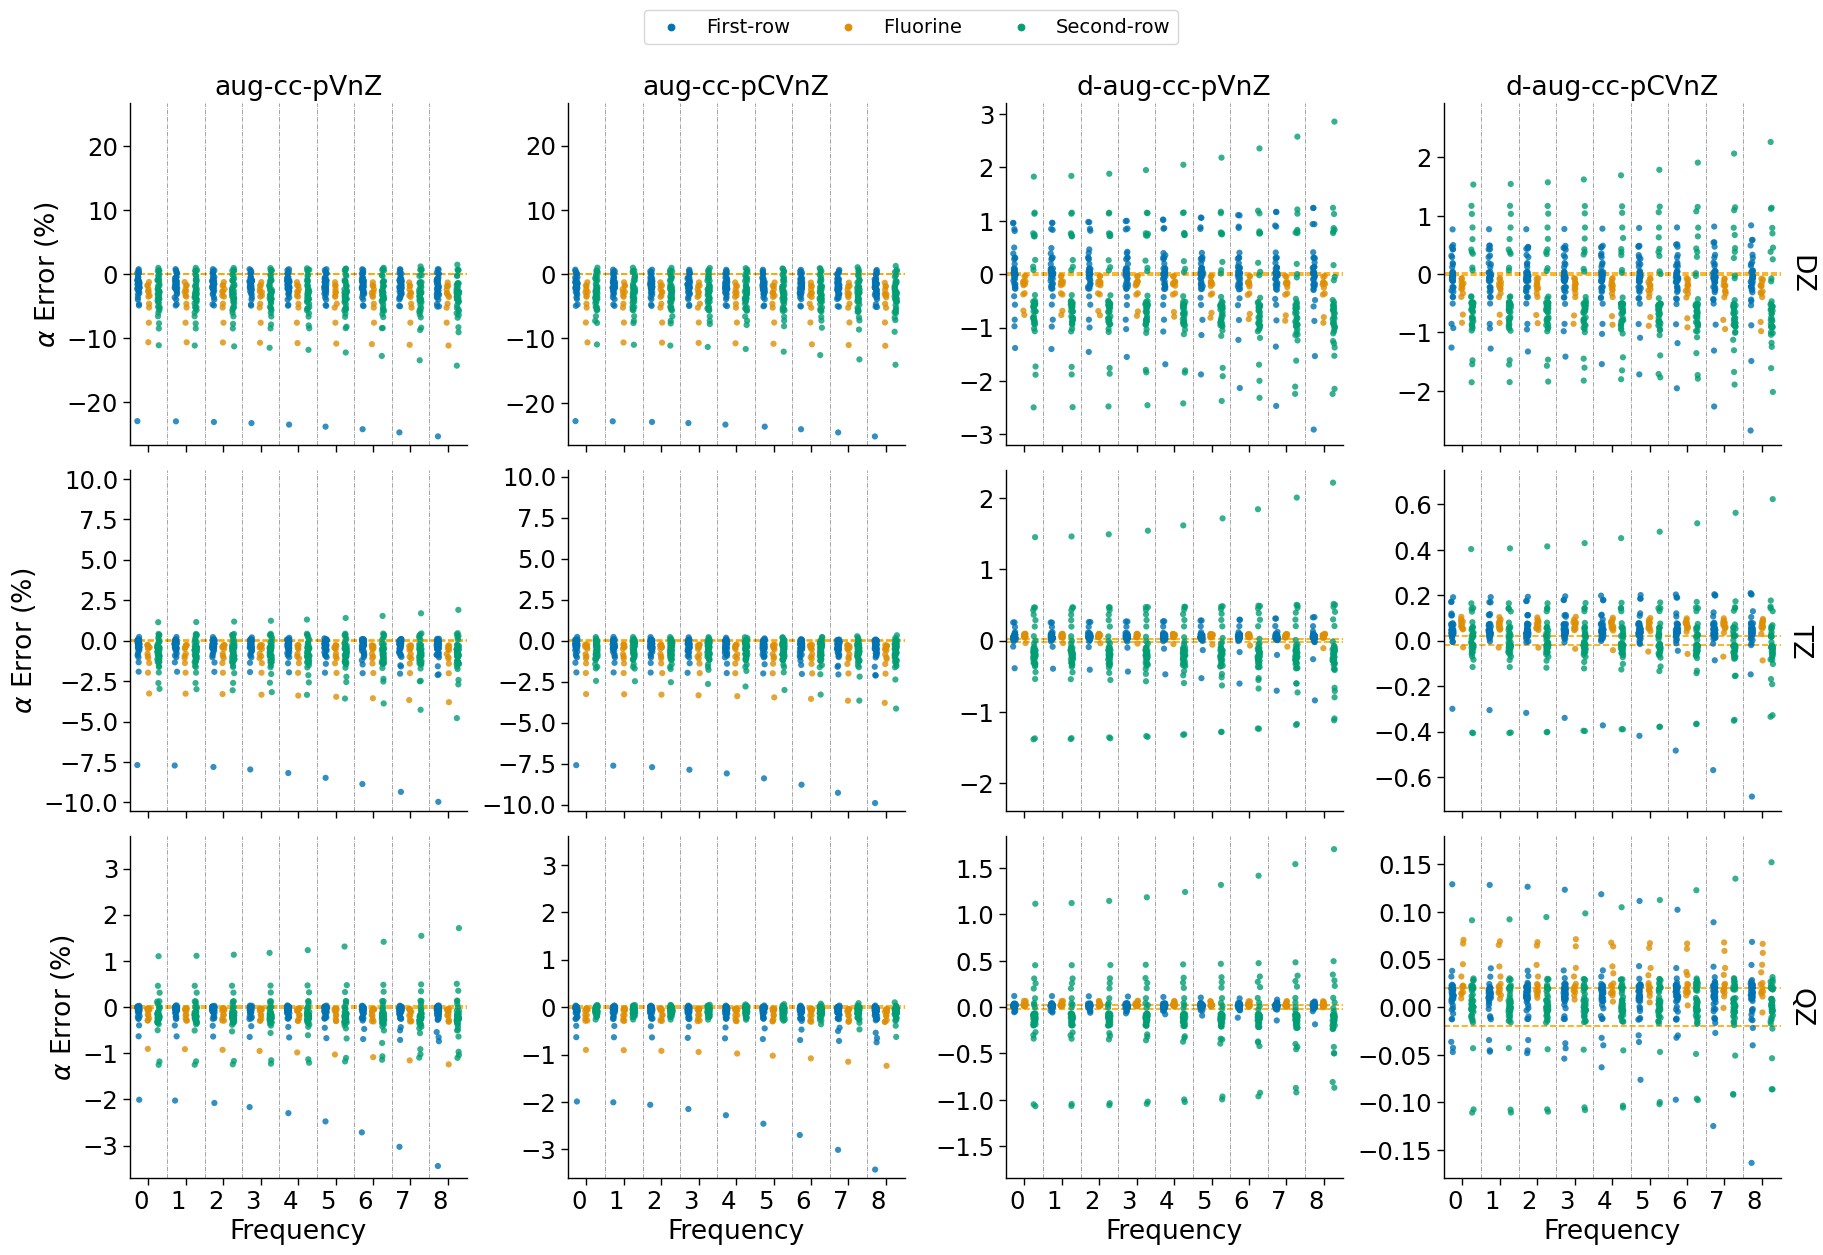

In [12]:
# Now make a plot of the frequency dependence of the error

vlevel = ['D', 'T', 'Q']
plot_data = basis_data.query('valence.isin(@vlevel)').copy()
# remove unused categories from valence
plot_data.valence = plot_data.valence.cat.remove_unused_categories()
with sns.plotting_context('paper', font_scale=2.00):
    facet_kws = {'margin_titles': True}
    g = sns.catplot(row='valence', col='Type',
                    x='omega',
                    y='alphaE', hue='mol_system',
                    data=plot_data, kind='strip', dodge=True, jitter=True,
                    s=20, palette='colorblind', height=4, aspect=1.0, sharex=True, sharey=False,
                    alpha=0.8,
                    margin_titles=True, facet_kws=facet_kws)

    # adjust the title to read D=$\zeta$D, T=$\zeta$T, etc.
    g.set_titles(col_template='{col_name}', row_template='{row_name}Z')

    g.set_xlabels('Frequency')
    for ax in g.axes.flat:
        # draw horizontal line at .05%rue
        #ax.set_yscale('symlog', linthresh=1e-1)
        ax.axhline(y=.02, linestyle='--', color='orange')
        ax.axhline(y=-.02, linestyle='--', color='orange')
        # for the symlog scale to regular notation with no decimal places for the y axis

        # make the y limits symmetrical for each plot using the max absolute value
        max_lim = max(abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))
        ax.set_ylim(-max_lim, max_lim)
        # remove the y axis label if not the first column
        if ax.get_subplotspec().colspan.start != 0:
            ax.set_ylabel('')
        else:
            ax.set_ylabel(r'$\alpha$ Error (%)')

        #ax.set_ylabel(r'$\alpha$ Error (%)')
        # rotate the xlabels
        for label in ax.get_xticklabels():
            label.set_horizontalalignment('right')

        # create vertical lines to separate basis sets
        for i in range(1, len(plot_data.omega.unique())):
            ax.axvline(i - .5, linestyle='-.', color='k', linewidth=.5, alpha=0.5)

# remove legend and create a new legend in 3 column format outside the plot
g._legend.remove()
# rename legend title
#g._legend.set_title('Subset')
g.fig.tight_layout()
g.fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, fontsize=14)
g.fig.savefig(paper_path.joinpath('alpha_freq_error.png'), dpi=600, bbox_inches='tight')


In [13]:
# query molecules with alphaE.abs()>.2 in singly augmented 5Z basis
plot_data = basis_data.query('valence=="5" and augmentation=="aug" and alphaE.abs()>.2').copy()
mol5 = plot_data.molecule.unique()

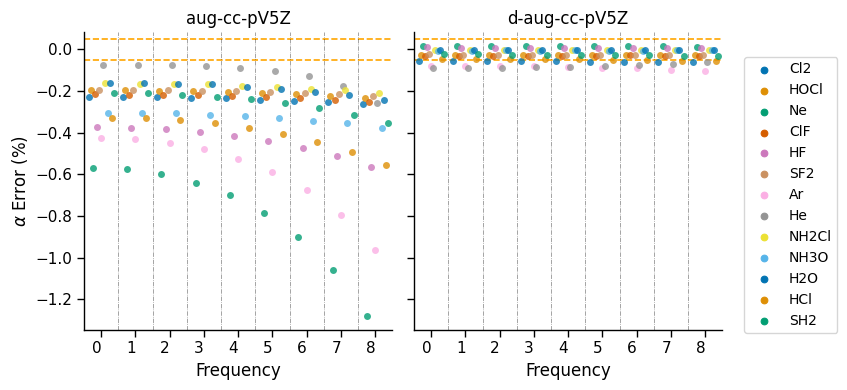

In [14]:
vlevel = ['5']
plot_data = basis_data.query('valence.isin(@vlevel) and molecule.isin(@mol5)').copy()
# remove unused categories from valence
plot_data.valence = plot_data.valence.cat.remove_unused_categories()
with sns.plotting_context('paper', font_scale=1.25):
    g = sns.catplot(row='valence', col='augmentation',
                    x='omega',
                    y='alphaE', hue='molecule',
                    data=plot_data, kind='strip', dodge=True, jitter=False,
                    s=25, palette='colorblind', height=4, aspect=.8, sharex=True, sharey=True,
                    alpha=0.8,
                    margin_titles=True)
    # adjust the title to read D=$\zeta$D, T=$\zeta$T, etc.
    g.set_titles('{col_name}-cc-pV{row_name}Z')

    g.set_xlabels('Frequency')
    for ax in g.axes.flat:
        # draw horizontal line at .05%rue
        #ax.set_yscale('symlog', linthresh=1e-2)
        ax.axhline(y=.05, linestyle='--', color='orange')
        ax.axhline(y=-.05, linestyle='--', color='orange')
        # for the symlog scale to regular notation with no decimal places for the y axis

        # make the y limits symmetrical for each plot using the max absolute value
        max_lim = max(abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))

        ax.set_ylabel(r'$\alpha$ Error (%)')
        # rotate the xlabels
        for label in ax.get_xticklabels():
            label.set_horizontalalignment('right')

        # create vertical lines to separate basis sets
        for i in range(1, len(plot_data.omega.unique())):
            ax.axvline(i - .5, linestyle='-.', color='k', linewidth=.5, alpha=.5)
        # remove the legend title
g.fig.tight_layout()
# rename legend title Molecule
g._legend.remove()
g.fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.50), ncol=1, fancybox=True)

g.fig.savefig(paper_path.joinpath('alpha_freq_error_5Z_outliers.png'), dpi=600, bbox_inches='tight')


In [15]:
# query molecules with alphaE.abs()>.2 in singly augmented 5Z basis
plot_data = basis_data.query('valence=="Q" and Type=="d-aug-cc-pVnZ" and alphaE.abs()>.25').copy()
daug_outliers = plot_data.molecule.unique()
plot_data = basis_data.query('valence=="Q" and Type=="aug-cc-pVnZ" and alphaE.abs()>.6').copy()
aug_outliers = plot_data.molecule.unique()





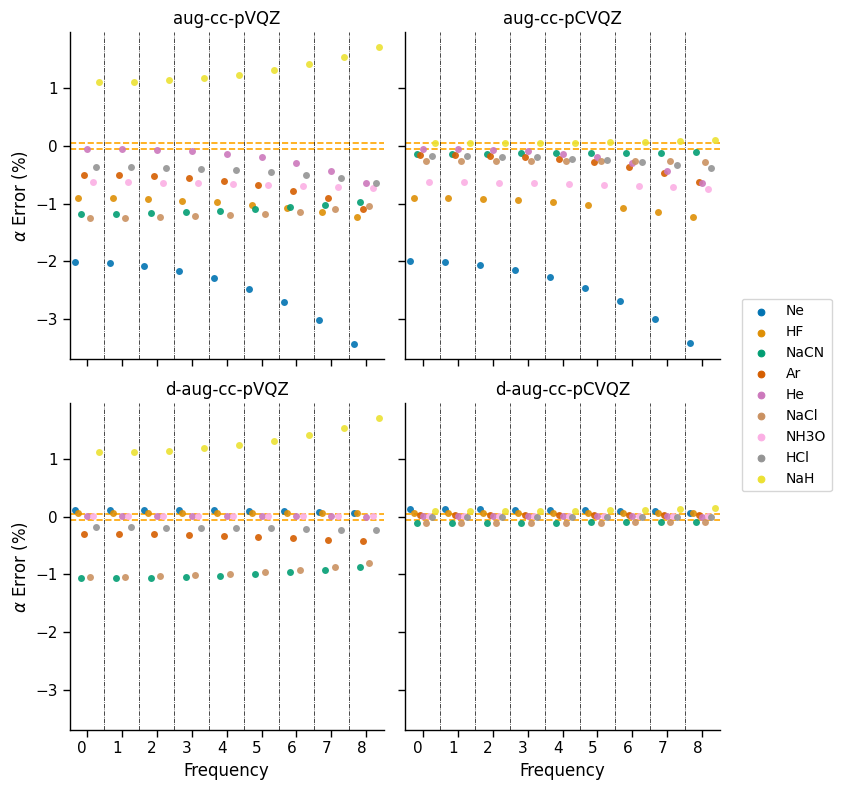

In [16]:
vlevel = ['Q']
plot_data = (basis_data.query('valence.isin(@vlevel) & molecule.isin(@aug_outliers)')
             .copy())
# remove unused categories from valence
plot_data.valence = plot_data.valence.cat.remove_unused_categories()
with sns.plotting_context('paper', font_scale=1.25):
    g = sns.catplot(row='augmentation', col='polarization', col_order=['V', 'CV'],
                    x='omega',
                    y='alphaE', hue='molecule',
                    data=plot_data, kind='strip', dodge=True, jitter=False,
                    s=25, palette='colorblind', height=4, aspect=.8, sharex=True, sharey=True,
                    alpha=0.9,
                    margin_titles=True)
    # adjust the title to read D=$\zeta$D, T=$\zeta$T, etc.
    g.set_titles("{col_name}-cc-pVQZ")

    g.set_xlabels('$\omega(i)$')
    g.set_xlabels('Frequency')
    for ax in g.axes.flat:
        # draw horizontal line at .05%rue
        #ax.set_yscale('symlog', linthresh=1e-2)
        ax.axhline(y=.05, linestyle='--', color='orange')
        ax.axhline(y=-.05, linestyle='--', color='orange')
        # for the symlog scale to regular notation with no decimal places for the y axis

        # make the y limits symmetrical for each plot using the max absolute value
        max_lim = max(abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))

        g.set_titles('{row_name}-cc-p{col_name}QZ')

        ax.set_ylabel(r'$\alpha$ Error (%)')
        # rotate the xlabels
        for label in ax.get_xticklabels():
            label.set_horizontalalignment('right')

        # create vertical lines to separate basis sets
        for i in range(1, len(plot_data.omega.unique())):
            ax.axvline(i - .5, linestyle='-.', color='k', linewidth=.5)
        # remove the legend title

g.fig.tight_layout()
g._legend.remove()
g.fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.50), ncol=1, fancybox=True)
g.fig.savefig(paper_path.joinpath('alpha_freq_error_augQ_outliers.png'), dpi=600,
              bbox_inches='tight')


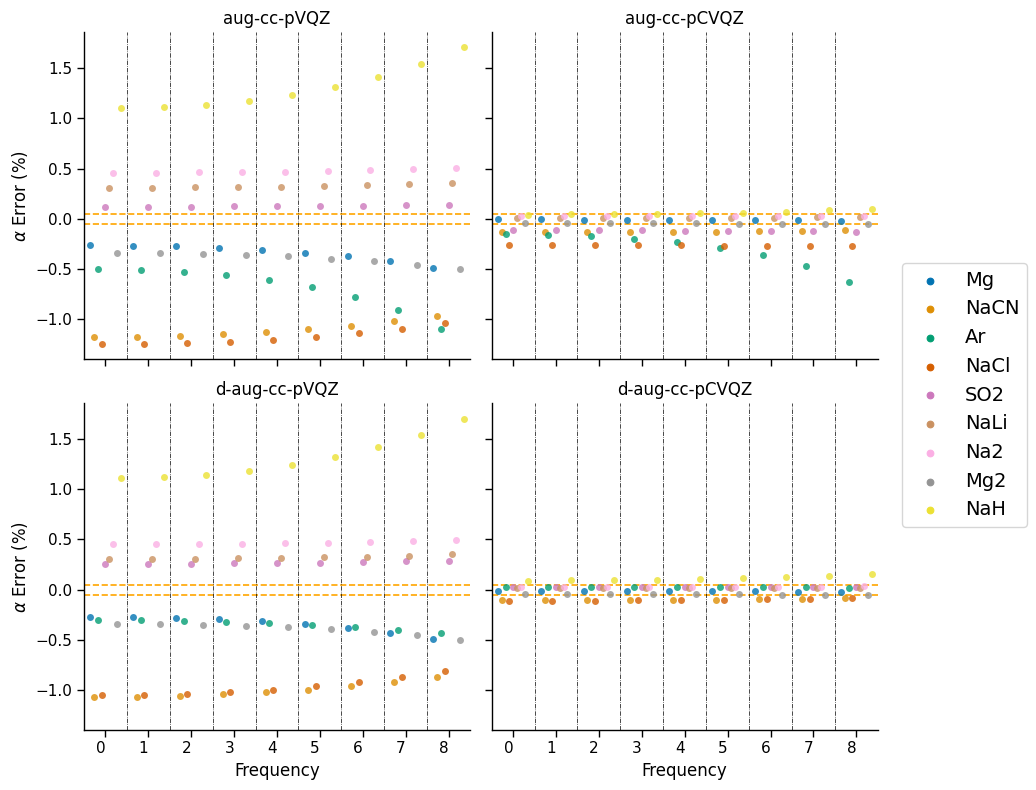

In [17]:
vlevel = ['Q']
plot_data = (basis_data.query('valence.isin(@vlevel) & molecule.isin(@daug_outliers)').copy())
# remove unused categories from valence
plot_data.valence = plot_data.valence.cat.remove_unused_categories()
with sns.plotting_context('paper', font_scale=1.25):
    g = sns.catplot(row='augmentation', col='polarization', col_order=['V', 'CV'],
                    x='omega',
                    y='alphaE', hue='molecule',
                    data=plot_data, kind='strip', dodge=True, jitter=False,
                    s=25, palette='colorblind', height=4, aspect=1, sharex=True, sharey=True,
                    alpha=0.8,
                    margin_titles=True)
    # adjust the title to read D=$\zeta$D, T=$\zeta$T, etc.
    g.set_titles('{row_name}-cc-p{col_name}QZ')

    g.set_xlabels('Frequency')
    for ax in g.axes.flat:
        # draw horizontal line at .05%rue
        #ax.set_yscale('symlog', linthresh=1e-2)
        ax.axhline(y=.05, linestyle='--', color='orange')
        ax.axhline(y=-.05, linestyle='--', color='orange')
        # for the symlog scale to regular notation with no decimal places for the y axis

        # make the y limits symmetrical for each plot using the max absolute value
        max_lim = max(abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))

        ax.set_ylabel(r'$\alpha$ Error (%)')
        # rotate the xlabels
        for label in ax.get_xticklabels():
            label.set_horizontalalignment('right')

        # create vertical lines to separate basis sets
        for i in range(1, len(plot_data.omega.unique())):
            ax.axvline(i - .5, linestyle='-.', color='k', linewidth=.5)
        # remove the legend title

g.fig.tight_layout()
g._legend.remove()
g.fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.50), ncol=1, fancybox=True, fontsize=14)

g.fig.savefig(paper_path.joinpath('alpha_freq_error_daugQ_outliers.png'), dpi=600,
              bbox_inches='tight')


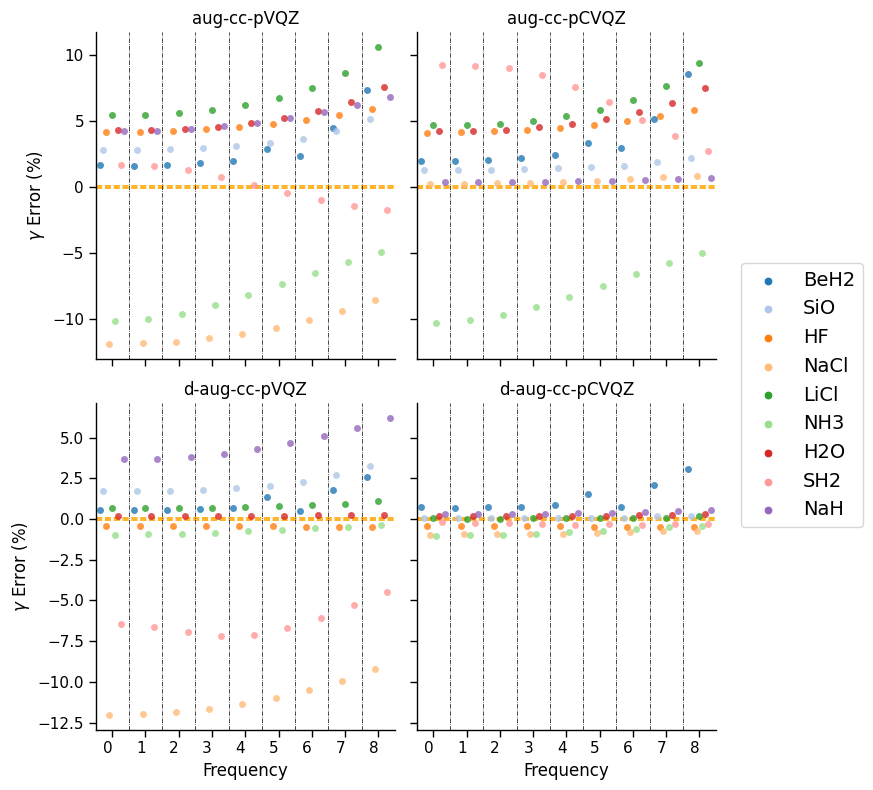

In [18]:

# Now make a plot of the frequency dependence of the error

# query molecules with alphaE.abs()>.2 in singly augmented 5Z basis
plot_data = basis_data.query('valence=="Q" and gammaE.abs()>4.0 & gamma.abs()>1e-3').copy()
gamma_outliers = plot_data.molecule.unique()

vlevel = ['Q']
plot_data = basis_data.query(
    'valence.isin(@vlevel) & gamma.abs()>1e-3 & molecule.isin(@gamma_outliers)').copy()
# remove unused categories from valence
plot_data.valence = plot_data.valence.cat.remove_unused_categories()
with sns.plotting_context('paper', font_scale=1.25):
    facet_kws = {'margin_titles': True}
    g = sns.catplot(row='augmentation', col='polarization',
                    x='omega',
                    y='gammaE', hue='molecule', col_order=['V', 'CV'],
                    data=plot_data, kind='strip', dodge=True, jitter=False,
                    s=25, palette='tab20', height=4, aspect=.8, sharex=True, sharey='row',
                    alpha=0.8,
                    margin_titles=True, )
    # adjust the title to read D=$\zeta$D, T=$\zeta$T, etc.
    g.set_titles('{row_name}-cc-p{col_name}QZ')
    g.set_xlabels('Frequency')
    for ax in g.axes.flat:
        # draw horizontal line at .05%rue
        #ax.set_yscale('symlog', linthresh=1e-2)
        ax.axhline(y=.05, linestyle='--', color='orange')
        ax.axhline(y=-.05, linestyle='--', color='orange')
        # for the symlog scale to regular notation with no decimal places for the y axis

        # make the y limits symmetrical for each plot using the max absolute value
        max_lim = max(abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))

        ax.set_ylabel(r'$\gamma$ Error (%)')
        # rotate the xlabels
        for label in ax.get_xticklabels():
            label.set_horizontalalignment('right')

        # create vertical lines to separate basis sets
        for i in range(1, len(plot_data.omega.unique())):
            ax.axvline(i - .5, linestyle='-.', color='k', linewidth=.5)
        # remove the legend title

g.fig.tight_layout()
g._legend.remove()
g.fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.50), ncol=1, fancybox=True, fontsize=14)

g.fig.savefig(paper_path.joinpath('gamma_freq_error.png'), dpi=600, bbox_inches='tight')


In [31]:

ij_basis_data=MRAComparedBasisDF(august_database.alpha_eigen, ['molecule', 'ij', 'omega'], ['alpha'],True)


['D', 'T', 'Q', '5', '6']


In [32]:
# query molecules with alphaE.abs()>.2 in singly augmented 5Z basis
plot_data = basis_data.query('valence=="Q" and gammaE.abs()>4.0 & gamma>1e-3').copy()
gamma_outliers = plot_data.molecule.unique()
gamma_outliers.tolist()




['BeH2', 'SiO', 'HF', 'NaCl', 'LiCl', 'NH3', 'H2O', 'SH2', 'NaH']

/tmp/ipykernel_10929/3370781752.py:10: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  g = sns.relplot(col='molecule', col_wrap=2,
/tmp/ipykernel_10929/3370781752.py:23: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(y=.05, linestyle='--', color='orange')
/tmp/ipykernel_10929/3370781752.py:24: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(y=-.05, linestyle='--', color='orange')


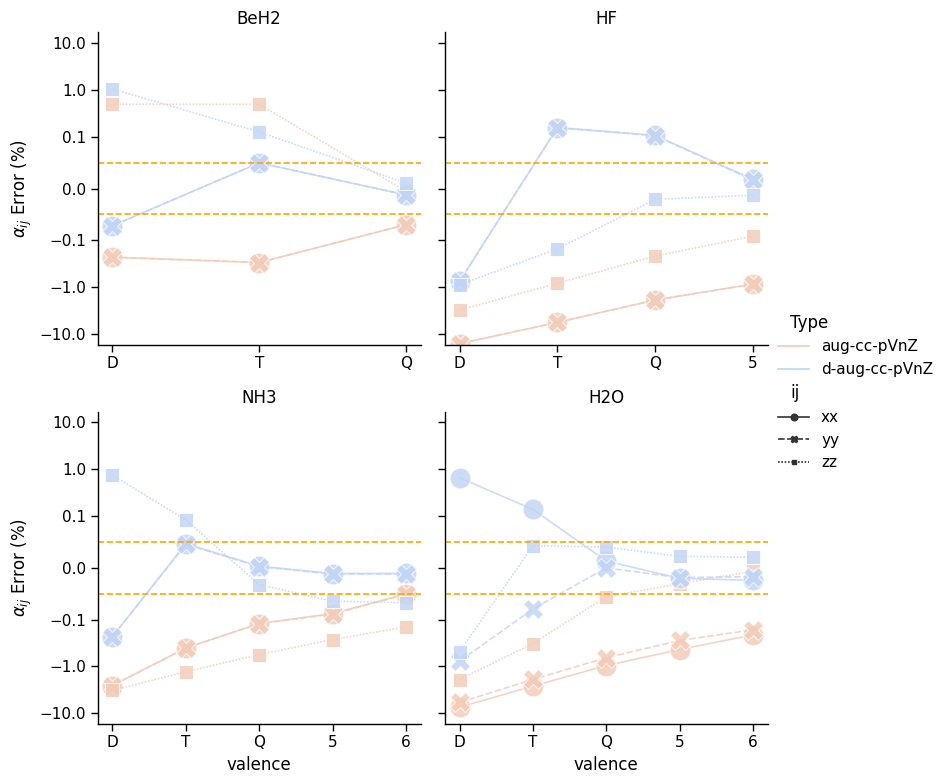

In [34]:
facet_kw = {'sharey': True, 'sharex': False}
ms = ['First-row', 'Fluorine']
type = ['aug-cc-pVnZ', 'd-aug-cc-pVnZ']

p_data = ij_basis_data.query('molecule.isin(@gamma_outliers) and mol_system.isin'
                             '(@ms) & Type.isin(@type) & omega==8').copy()
p_data.Type = p_data.Type.cat.remove_unused_categories()
# plot valence vs alpha error with component hue for each molecule
with sns.plotting_context('paper', font_scale=1.25, ):
    g = sns.relplot(col='molecule', col_wrap=2,
                    x='valence', y='alphaE', style='ij', hue='Type', kind='line',
                    data=p_data,
                    palette=simple_pal,
                    markers=True,
                    height=4, aspect=1, facet_kws=facet_kw, ms=15, alpha=.8, )
    # adjust the title to read D=$\zeta$D, T=$\zeta$T, etc.
    g.set_titles(col_template='{col_name}')
    g.set_ylabels(r'$\alpha_{ij}$ Error (%)')

    for ax in g.axes.flat:
        # draw horizontal line at .05%rue
        ax.set_yscale('symlog', linthresh=1e-1)
        ax.axhline(y=.05, linestyle='--', color='orange')
        ax.axhline(y=-.05, linestyle='--', color='orange')
        # set the yaxis to scalar formatter
        ax.yaxis.set_major_formatter(ScalarFormatter())
        # make the y limits symmetrical for each plot using the max absolute value
        max_lim = max(abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))
        ax.set_ylim(-max_lim, max_lim)

g.savefig(paper_path.joinpath('first_and_fluorine_component_error.png'), dpi=600)



/tmp/ipykernel_10929/1812512562.py:26: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(y=.05, linestyle='--', color='orange')
/tmp/ipykernel_10929/1812512562.py:27: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(y=-.05, linestyle='--', color='orange')


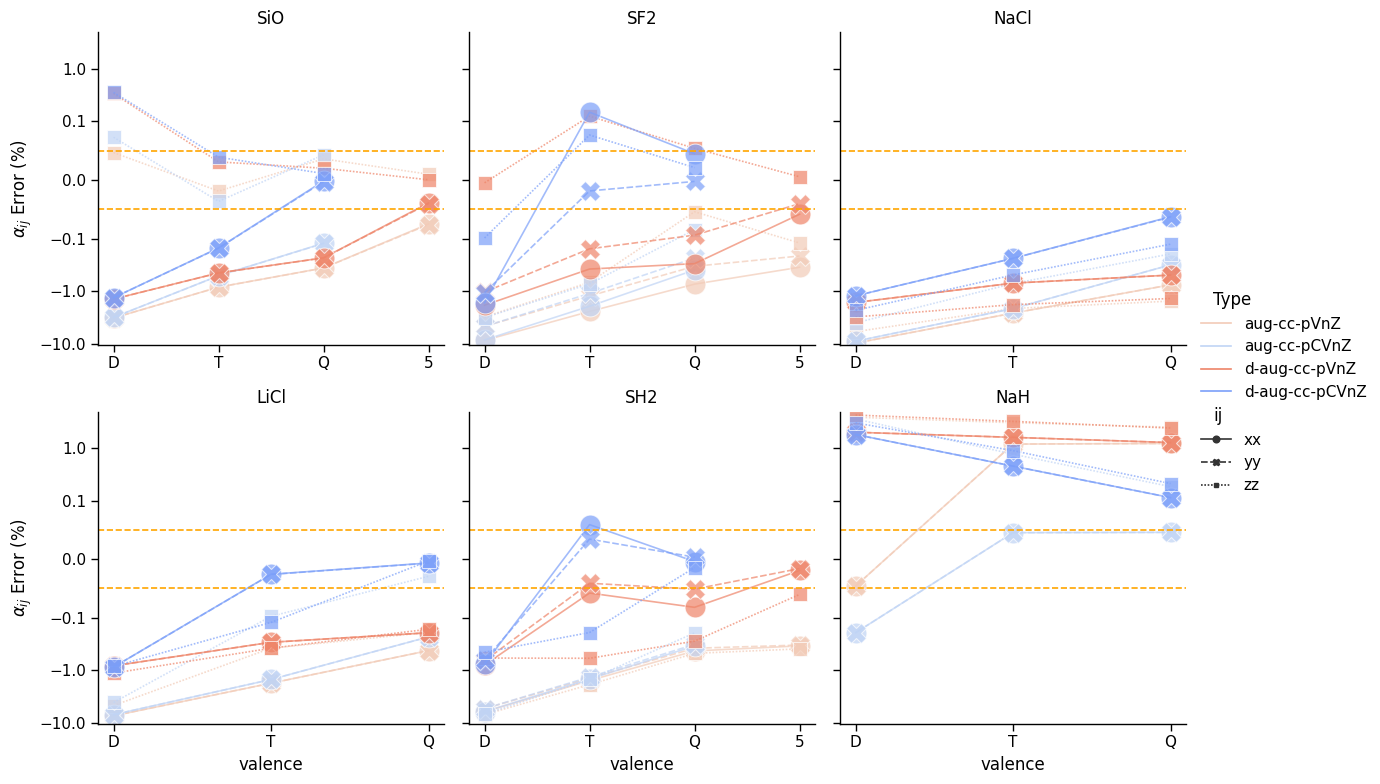

In [36]:
    
gamma_outliers = plot_data.molecule.unique()
gamma_outliers.tolist()

gamma_outliers = gamma_outliers.tolist() + ['SF2']
ms = ['Second-row']
p_data = ij_basis_data.query('molecule.isin(@gamma_outliers) and mol_system.isin'
                             '(@ms) and omega==8')
#remove 
facet_kw = {'sharey': True, 'sharex': False}
# plot valence vs alpha error with component hue for each molecule
with sns.plotting_context('paper', font_scale=1.25, ):
    g = sns.relplot(col='molecule',
                    x='valence', y='alphaE', style='ij', hue='Type', kind='line',
                    data=p_data,
                    palette=simple_pal,
                    markers=True,
                    col_wrap=3,
                    height=4, aspect=1, facet_kws=facet_kw, ms=15, alpha=.7)
    # adjust the title to read D=$\zeta$D, T=$\zeta$T, etc.
    g.set_titles(col_template='{col_name}')
    g.set_ylabels(r'$\alpha_{ij}$ Error (%)')

    for ax in g.axes.flat:
        # draw horizontal line at .05%rue
        ax.set_yscale('symlog', linthresh=1e-1)
        ax.axhline(y=.05, linestyle='--', color='orange')
        ax.axhline(y=-.05, linestyle='--', color='orange')
        # set the yaxis to scalar formatter
        ax.yaxis.set_major_formatter(ScalarFormatter())
        # make the y limits symmetrical for each plot using the max absolute value
        max_lim = max(abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))

g.savefig(paper_path.joinpath('component_error.png'), dpi=600)


In [43]:
basis_e_data=MRAComparedBasisDF(august_database.energy_df, ['molecule'], ['energy'], False)
basis_e_data

['D', 'T', 'Q', '5', '6']


,molecule,basis,energy,energyMRA,energyE,augmentation,polarization,mol_system,valence,Type
0,FNO,aug-cc-pVDZ,-228.654307,-228.729667,0.075360,aug,V,Fluorine,D,aug-cc-pVnZ
1,CH3SH,aug-cc-pVDZ,-437.728961,-437.765346,0.036385,aug,V,Second-row,D,aug-cc-pVnZ
2,C2H4,aug-cc-pVDZ,-78.043348,-78.070057,0.026709,aug,V,First-row,D,aug-cc-pVnZ
3,H2,aug-cc-pVDZ,-1.128793,-1.133622,0.004829,aug,V,First-row,D,aug-cc-pVnZ
4,Cl2,aug-cc-pVDZ,-918.966004,-919.010810,0.044806,aug,V,Second-row,D,aug-cc-pVnZ
...,...,...,...,...,...,...,...,...,...,...
1243,NaH,d-aug-cc-pCVQZ,-162.392976,-162.393346,0.000370,d-aug,CV,Second-row,Q,d-aug-cc-pCVnZ
1244,OF2,d-aug-cc-pCVQZ,-273.582100,-273.587208,0.005108,d-aug,CV,Fluorine,Q,d-aug-cc-pCVnZ
1245,HNC,d-aug-cc-pCVQZ,-92.899010,-92.900113,0.001103,d-aug,CV,First-row,Q,d-aug-cc-pCVnZ
1246,BH2F,d-aug-cc-pCVQZ,-125.384224,-125.386511,0.002287,d-aug,CV,Fluorine,Q,d-aug-cc-pCVnZ


/tmp/ipykernel_10929/816802600.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xl)


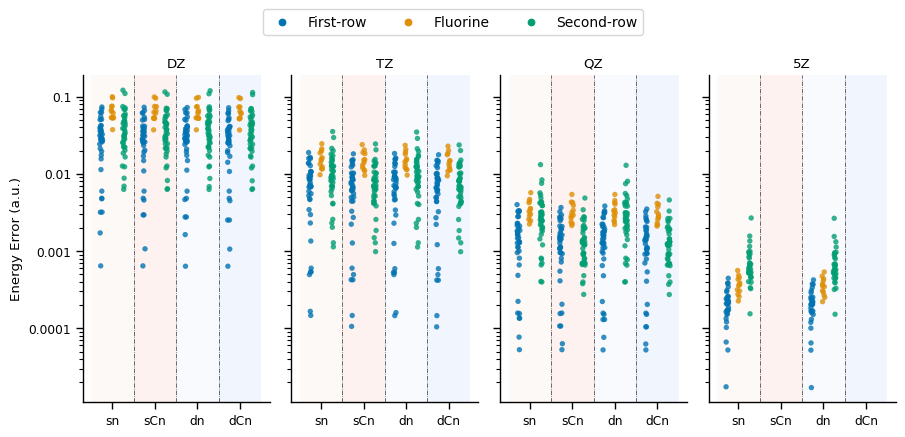

In [45]:
vlevel = ['D', 'T', 'Q', '5']
plot_data = basis_e_data.query('valence.isin(@vlevel)').copy()
# remove unused categories from valence
plot_data.valence = plot_data.valence.cat.remove_unused_categories()
with sns.plotting_context('paper', font_scale=1.00):
    g = sns.catplot(col='valence', x='Type', y='energyE', hue='mol_system',
                    data=plot_data, kind='strip', dodge=True, jitter=True,
                    s=15, palette='colorblind', height=4, aspect=aspect_ratio, sharey=True,
                    alpha=0.8)
    # adjust the title to read D=$\zeta$D, T=$\zeta$T, etc.
    g.set_titles('{col_name}Z')
    g.set_xlabels('')

    for ax in g.axes.flat:
        # draw horizontal line at .05%
        ax.set_yscale('log')
        #ax.axhline(y=.05,linestyle='--',color='orange')
        #ax.axhline(y=-.05,linestyle='--',color='orange')
        # for the symlog scale to regular notation with no decimal places for the y axis
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.yaxis.set_major_formatter(FormatStrFormatter('%2g'))
        # on each axis divide the background into 4 regions horizontally and color the background 
        # of each region a different color
        xl = ['sn', 'sCn', 'dn', 'dCn']
        ax.set_xticklabels(xl)

        ax.set_ylabel(r'Energy Error (a.u.)')
        # rotate the xlabels
        # create vertical lines to separate basis sets
        for i in range(1, len(plot_data.Type.unique())):
            ax.axvline(i - .5, linestyle='-.', color='k', linewidth=.5, alpha=.8)

        for i in range(1, 5):
            ax.axvspan((i - 1) - .5, i - .5, 1e-3, facecolor=pal[i - 1], alpha=0.1)
        # remove the legend title

# remove legend and create a new legend in 3 column format outside the plot
g._legend.remove()
g.fig.legend(loc='center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, fontsize=10)
g.fig.tight_layout()

g.fig.savefig(paper_path.joinpath('energy_error.png'), dpi=600, bbox_inches='tight')


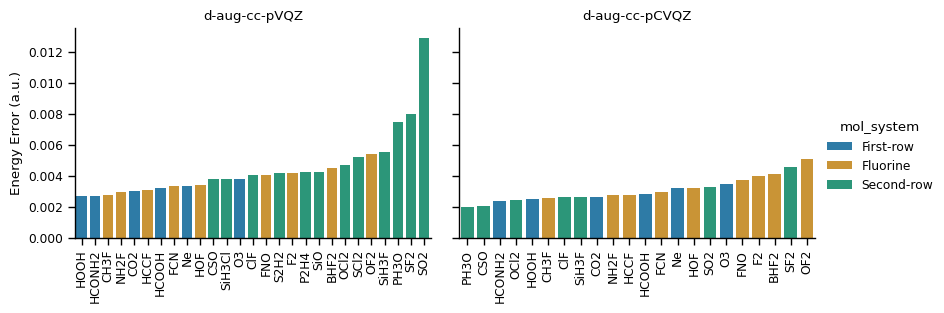

In [49]:

daug_outliers = (basis_e_data.query('valence=="Q" & basis=="d-aug-cc-pVQZ" ').sort_values
                 ('energyE',
                  ascending=False).head(20)).molecule.unique()
daugC_outliers = (basis_e_data.query('valence=="Q" & basis=="d-aug-cc-pCVQZ"').sort_values
                  ('energyE',
                   ascending=False).head(20)).molecule.unique()
e_outliers = daug_outliers.tolist() + daugC_outliers.tolist()
e_outliers = (basis_e_data.query("molecule.isin(@e_outliers) & valence=='Q' & "
                                 "augmentation=='d-aug'")
              )
# remove any values less with abs less than 0.02
e_outliers = e_outliers.query('energyE.abs()>.002').sort_values('energyE', ascending=True)

with sns.plotting_context('paper', font_scale=1.00):
    #g = sns.FacetGrid(data=e_outliers, col='polarization', hue='mol_system', sharey=True,
    #                  sharex=False, aspect=2.0, height
    #                  =10, col_order=['V', 'CV'])
    #g.map(sns.barplot, 'molecule', 'eE', 'basis',  alpha=.9)
    ## adjust title to read d-aug-cc-pVQZ
    # color the bars based on molecules mol_system typeo
    g = sns.catplot(x='molecule', y='energyE',
                    hue='mol_system',
                    col='polarization', col_order=['V', 'CV'],
                    data=e_outliers, dodge=False,
                    alpha=.9, palette='colorblind', fill=True, height=3, aspect=1.4, kind='bar',
                    sharex=False
                    )
    g.set_titles('d-aug-cc-p{col_name}QZ')
    g.set_xlabels('')
    g.set_ylabels('Energy Error (a.u.)')
    # rotate the xticks
    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(90)
            label.set_horizontalalignment('center')
    # remove legend title
    # create a new legend in 3 column format outside the plot
    # using only a single legend only using the second axis
    g.fig.savefig(paper_path.joinpath('energy_error_outliers.png'), dpi=600, bbox_inches='tight')

['NaH', 'NaCN', 'NaCl', 'Na2', 'Mg2', 'NaLi', 'Ar', 'Mg', 'SO2', 'PH3O', 'HCCCl', 'ClCN', 'Cl2', 'HCl', 'LiCl', 'BH2Cl', 'CSO', 'SCl2', 'S2H2', 'CH3Cl', 'Ne', 'NaCl', 'NaCN', 'NaH', 'F2', 'HF', 'H2', 'HOF', 'Mg2', 'Be', 'LiBH4', 'O3', 'NH2F', 'N2', 'Ar', 'Na2', 'SO2', 'HBO', 'NH2Cl', 'FCN']


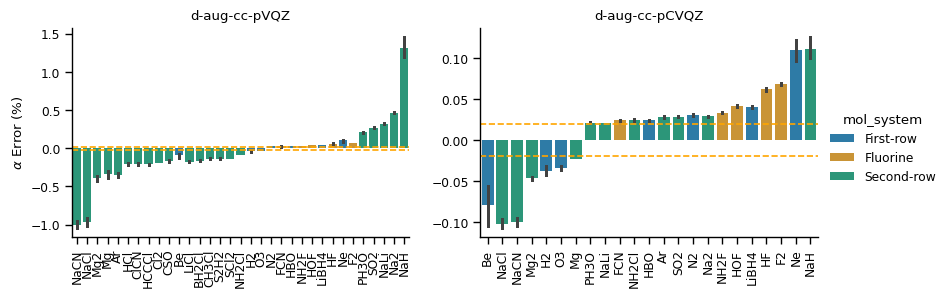

In [50]:

basis_data['absolute_alphaE'] = basis_data.alphaE.abs()

daug_outliers = (basis_data.query('valence=="Q" & basis=="d-aug-cc-pVQZ" & omega==0').sort_values
                 ('absolute_alphaE',
                  ascending=False).head(20)).molecule.unique()
daugC_outliers = (basis_data.query('valence=="Q" & basis=="d-aug-cc-pCVQZ" & omega==0').sort_values
                  ('absolute_alphaE',
                   ascending=False).head(20)).molecule.unique()

a_outliers = daug_outliers.tolist() + daugC_outliers.tolist()
print(a_outliers)

a_outliers = (basis_data.query("molecule.isin(@a_outliers) & valence=='Q' & augmentation=='d-aug' ")
              .sort_values
              ('alphaE', ascending=True)
              .sort_values('alphaE'))
# remove any values less with abs less than 0.02
a_outliers = a_outliers.query('alphaE.abs()>.02')

with sns.plotting_context('paper', font_scale=1.00):
    #g = sns.FacetGrid(data=e_outliers, col='polarization', hue='mol_system', sharey=True,
    #                  sharex=False, aspect=2.0, height
    #                  =10, col_order=['V', 'CV'])
    #g.map(sns.barplot, 'molecule', 'eE', 'basis',  alpha=.9)
    ## adjust title to read d-aug-cc-pVQZ
    # color the bars based on molecules mol_system typeo
    g = sns.catplot(x='molecule', y='alphaE',
                    hue='mol_system',
                    col='polarization', col_order=['V', 'CV'],
                    data=a_outliers, dodge=False,
                    alpha=.9, palette='colorblind', fill=True, height=3, aspect=1.4, kind='bar'
                    , sharey=False,
                    sharex=False
                    )
    g.set_titles('d-aug-cc-p{col_name}QZ')
    g.set_xlabels('')
    g.set_ylabels(r'$\alpha$ Error (%)')
    # rotate the xticks
    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(90)
            label.set_horizontalalignment('center')
        # add a horizontal line at 0.02 and -0.02
        ax.axhline(y=.02, linestyle='--', color='orange')
        ax.axhline(y=-.02, linestyle='--', color='orange')
        # symlog scale
    # remove legend title
    # create a new legend in 3 column format outside the plot
    # using only a single legend only using the second axis
    g.fig.savefig(paper_path.joinpath('alpha_error_outliers.png'), dpi=600, bbox_inches='tight')


/tmp/ipykernel_10929/615339799.py:19: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(y=.02, linestyle='--', color='orange')
/tmp/ipykernel_10929/615339799.py:20: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(y=-.02, linestyle='--', color='orange')


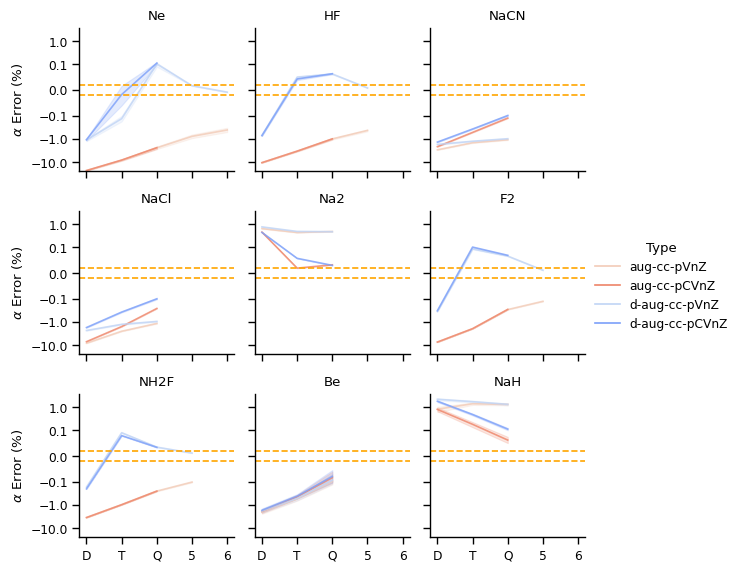

In [51]:
# make a plot of the frequency dependence of the error for a single molecule
mol = ['NaCl', 'NaCN', 'Na2', 'NaH', 'Be', 'NH2F', 'HF', 'F2', 'Ne']
plot_data = basis_data.query('molecule.isin(@mol)').copy()
# remove unused categories from valence
plot_data.valence = plot_data.valence.cat.remove_unused_categories()
# plot valence versus alpha error with component hue for Type

with sns.plotting_context('paper', font_scale=1.00):
    g = sns.relplot(x='valence', y='alphaE', hue='Type', kind='line', data=plot_data,
                    palette=pal, markers=True, height=2, aspect=1, alpha=.8, col='molecule', col_wrap=3)
    g.set_ylabels(r'$\alpha$ Error (%)')
    g.set_xlabels('')

    g.set_titles('{col_name}')

    # symlog scale
    for ax in g.axes.flat:
        ax.set_yscale('symlog', linthresh=1e-1)
        ax.axhline(y=.02, linestyle='--', color='orange')
        ax.axhline(y=-.02, linestyle='--', color='orange')
        # set the yaxis to scalar formatter
        ax.yaxis.set_major_formatter(ScalarFormatter())
    g.savefig(paper_path.joinpath('alpha_outlier_valence_error.png'), dpi=600, bbox_inches='tight')


In [53]:
basis_data
data = pd.DataFrame()
# for each frequency
for omega in basis_data.omega.unique():
    # filter data for frequency
    omega_data = basis_data.query('omega==@omega')
    # create the column for eE by first setting index to basis and molecule
    omega_data = omega_data.set_index(['basis', 'molecule'])
    # create a column of MRA energy data for each molecule omega pair
    omega_data['eE'] = basis_e_data.set_index(['basis', 'molecule'])['energyE']
    # reset index
    omega_data = omega_data.reset_index()
    # concat to full data
    data = pd.concat([data, omega_data])

bdata = data.copy()




/tmp/ipykernel_10929/2917842408.py:28: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(y=.02, linestyle='--', color='orange')
/tmp/ipykernel_10929/2917842408.py:29: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(y=-.02, linestyle='--', color='orange')


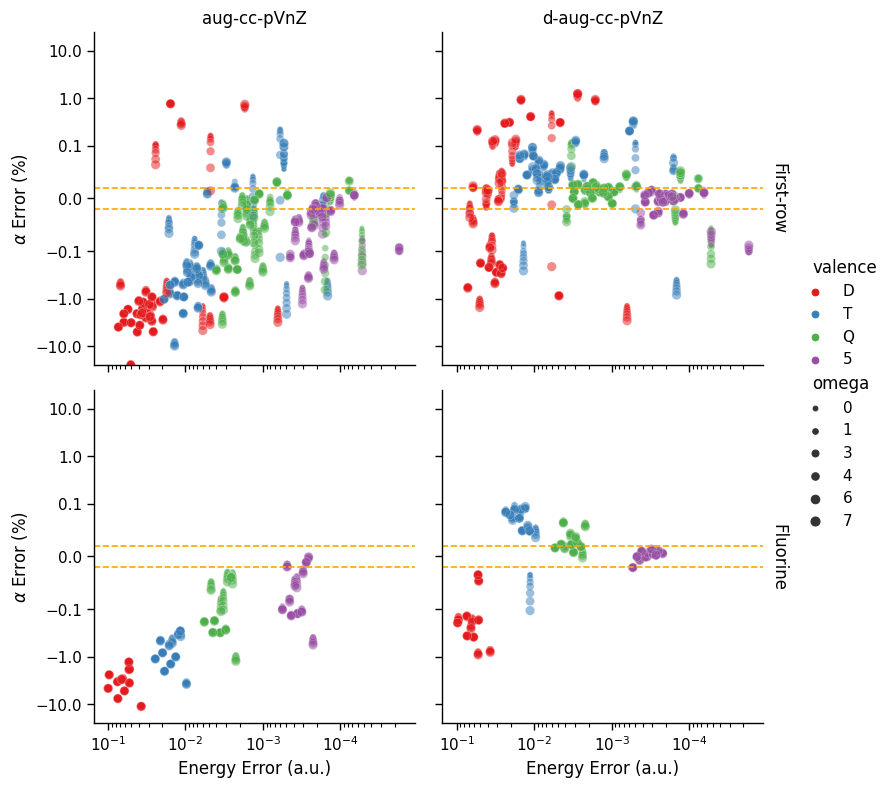

In [54]:
v_level = ['D', 'T', 'Q', '5']
omegas = [0, 1, 2, 3, 4, 5, 6, 7, 8]
molsys = ['First-row', 'Fluorine']
types = ['aug-cc-pVnZ', 'd-aug-cc-pVnZ']
data = (bdata.query(
    'valence.isin(@v_level) & omega.isin(@omegas) & mol_system.isin(@molsys) & Type.isin(@types) ')
        .copy())
data.valence = data.valence.cat.remove_unused_categories()
data.Type = data.Type.cat.remove_unused_categories()
data.mol_system = data.mol_system.cat.remove_unused_categories()
data['absolute_alphaE'] = data.alphaE.abs()

# relplot comparing energy error to alpha error
facet_kw = {"sharey": True, "sharex": True, "margin_titles": True}
with sns.plotting_context('paper', font_scale=1.25):
    g = sns.relplot(x='eE', y='alphaE', col='Type', hue='valence', data=data, kind='scatter',
                    size='omega',
                    legend=True,
                    row='mol_system',
                    palette='Set1', height=4, aspect=1,
                    alpha=0.5, facet_kws=facet_kw)
    g.set_xlabels('Energy Error (a.u.)')
    g.set_ylabels(r'$\alpha$ Error (%)')
    g.set_titles(row_template='{row_name}', col_template='{col_name}')
    for ax in g.axes.flat:
        ax.set_yscale('symlog', linthresh=1e-1)
        ax.set_xscale('log')
        ax.axhline(y=.02, linestyle='--', color='orange')
        ax.axhline(y=-.02, linestyle='--', color='orange')
        # reverse the x axis
        ax.set_xlim(ax.get_xlim()[::-1])
        # make the yaxis symmetrical
        max_lim = max(abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))
        ax.set_ylim(-25, 25)
        # use a scalar formatter for the y axis
        ax.yaxis.set_major_formatter(ScalarFormatter())
        # reverse the x axis

g.fig.gca().invert_xaxis()

g.fig.savefig(paper_path.joinpath('alpha_energy_error_1.png'), dpi=600)

# remove the legend title

/tmp/ipykernel_10929/2121599419.py:23: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(y=.02, linestyle='--', color='orange')
/tmp/ipykernel_10929/2121599419.py:24: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(y=-.02, linestyle='--', color='orange')


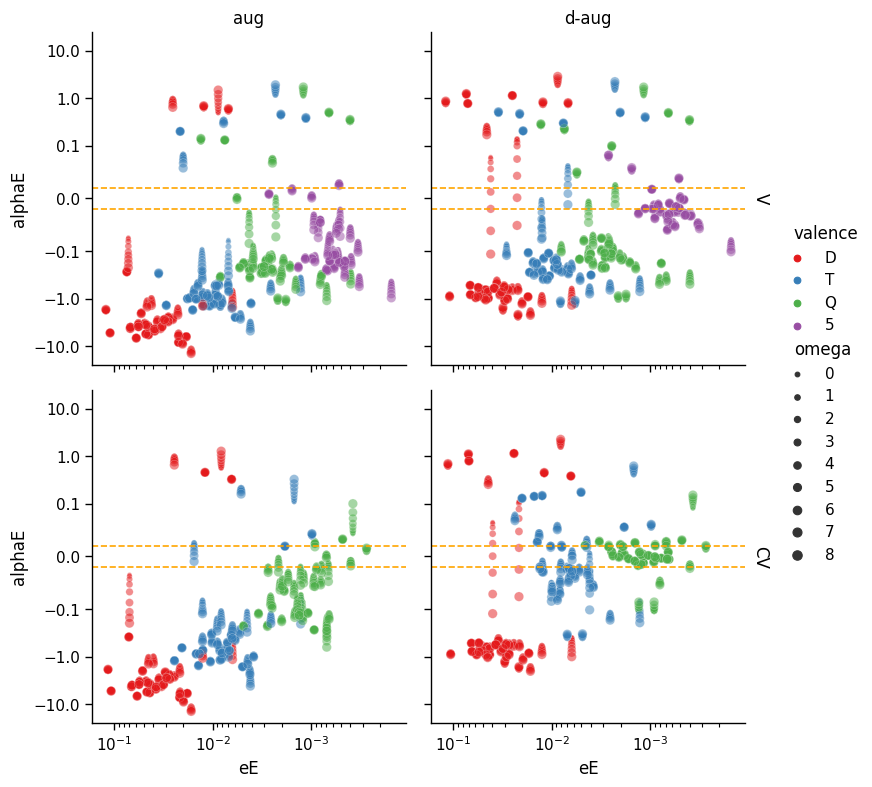

In [55]:
omegas = [0, 1, 2, 3, 4, 5, 6, 7, 8]
molsys = ['Second-row']
data = bdata.query(
    'valence.isin(@v_level) & omega.isin(@omegas) & mol_system.isin(@molsys) ').copy()
data.valence = data.valence.cat.remove_unused_categories()
data.mol_system = data.mol_system.cat.remove_unused_categories()
data['absolute_alphaE'] = data.alphaE.abs()

# relplot comparing energy error to alpha error
facet_kw = {"sharey": True, "sharex": True, "margin_titles": True}
with sns.plotting_context('paper', font_scale=1.25):
    g = sns.relplot(x='eE', y='alphaE', row='polarization', hue='valence', data=data,
                    kind='scatter', s=50,
                    row_order=['V', 'CV'],
                    col='augmentation',
                    size='omega',
                    palette='Set1', height=4, aspect=1, legend='full',
                    alpha=0.5, facet_kws=facet_kw)
    g.set_titles(row_template='{row_name}', col_template='{col_name}')
    for ax in g.axes.flat:
        ax.set_yscale('symlog', linthresh=1e-1)
        ax.set_xscale('log')
        ax.axhline(y=.02, linestyle='--', color='orange')
        ax.axhline(y=-.02, linestyle='--', color='orange')
        # reverse the x axis
        ax.set_xlim(ax.get_xlim()[::-1])
        # make the yaxis symmetrical
        max_lim = max(abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))
        ax.set_ylim(-25, 25)
        # use a scalar formatter for the y axis
        ax.yaxis.set_major_formatter(ScalarFormatter())
        # reverse the x axis

g.fig.gca().invert_xaxis()

g.fig.savefig(paper_path.joinpath('alpha_energy_error_2.png'), dpi=600)



/tmp/ipykernel_10929/2755361293.py:23: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(y=.02, linestyle='--', color='orange')
/tmp/ipykernel_10929/2755361293.py:24: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(y=-.02, linestyle='--', color='orange')


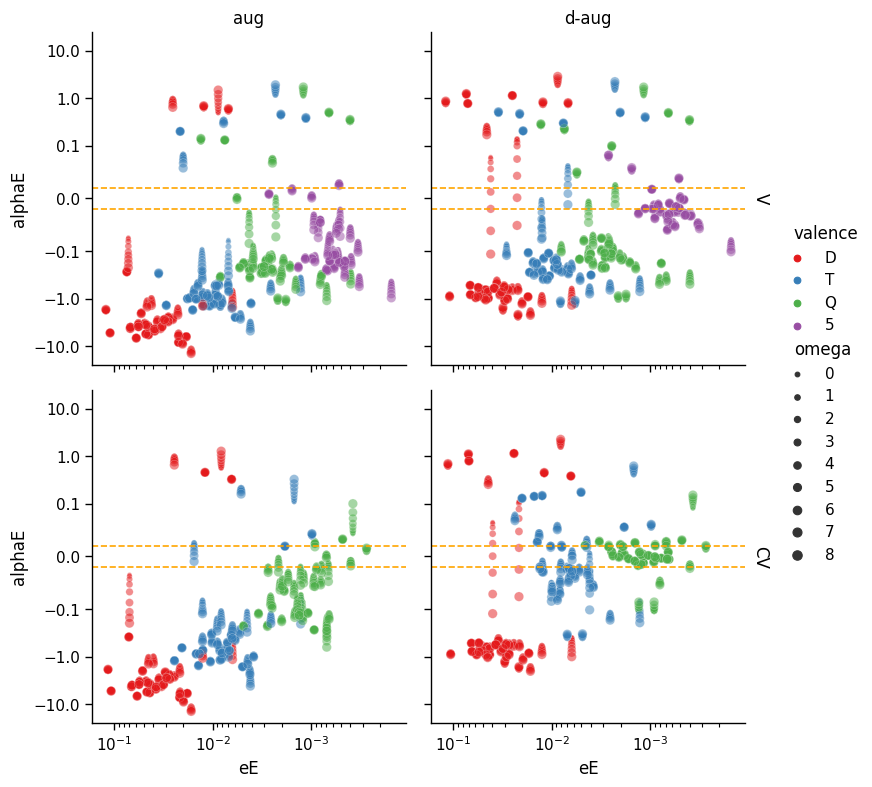

In [56]:
omegas = [0, 1, 2, 3, 4, 5, 6, 7, 8]
molsys = ['Second-row']
data = bdata.query(
    'valence.isin(@v_level) & omega.isin(@omegas) & mol_system.isin(@molsys) ').copy()
data.valence = data.valence.cat.remove_unused_categories()
data.mol_system = data.mol_system.cat.remove_unused_categories()
data['absolute_alphaE'] = data.alphaE.abs()

# relplot comparing energy error to alpha error
facet_kw = {"sharey": True, "sharex": True, "margin_titles": True}
with sns.plotting_context('paper', font_scale=1.25):
    g = sns.relplot(x='eE', y='alphaE', row='polarization', hue='valence', data=data,
                    kind='scatter', s=50,
                    row_order=['V', 'CV'],
                    col='augmentation',
                    size='omega',
                    palette='Set1', height=4, aspect=1, legend='full',
                    alpha=0.5, facet_kws=facet_kw)
    g.set_titles(row_template='{row_name}', col_template='{col_name}')
    for ax in g.axes.flat:
        ax.set_yscale('symlog', linthresh=1e-1)
        ax.set_xscale('log')
        ax.axhline(y=.02, linestyle='--', color='orange')
        ax.axhline(y=-.02, linestyle='--', color='orange')
        # reverse the x axis
        ax.set_xlim(ax.get_xlim()[::-1])
        # make the yaxis symmetrical
        max_lim = max(abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))
        ax.set_ylim(-25, 25)
        # use a scalar formatter for the y axis
        ax.yaxis.set_major_formatter(ScalarFormatter())
        # reverse the x axis

g.fig.gca().invert_xaxis()

g.fig.savefig(paper_path.joinpath('alpha_energy_error_2.png'), dpi=600)


In [ ]:
data

In [ ]:
basis_data

In [ ]:
basis_data.describe()['alphaE']

In [57]:
# for each basis set get the alphaE statistics and place them in a dataframe

iso_stats = pd.DataFrame()
for basis in basis_data.basis.unique():
    # filter data for basis
    subset = basis_data.query('basis==@basis & omega==0')
    # remove nan values row
    # get the mean and std of alphaE
    d = subset.describe()['alphaE']
    d.name = basis
    # concat to the full dataframe
    iso_stats = pd.concat([iso_stats, d], axis=1)
iso_stats = iso_stats.T



In [60]:
# write a function which does the above for a given omega and alphaE or gammaE
def basis_stats(iso_type, omega):
    iso_stats = pd.DataFrame()
    for basis in basis_data.basis.unique():
        # filter data for basis
        subset = basis_data.query('basis==@basis & omega==@omega')
        # remove nan values row
        if iso_type == 'gammaE':
            # drop any values with gammaE.abs() < 1e-3
            subset = subset.query('gamma.abs()>1e-3')
        # concat to the full dataframe
        # get the mean and std of alphaE
        d = subset.describe()[iso_type]
        d.name = basis
        iso_stats = pd.concat([iso_stats, d], axis=1)
    iso_stats = iso_stats.T
    # remove the 6Z basis set
    iso_stats = iso_stats.drop('aug-cc-pV6Z', axis=0)
    iso_stats = iso_stats.drop('d-aug-cc-pV6Z', axis=0)
    return iso_stats


# write a function which does the above for a given omega and alphaE or gammaE
def basis_e_stats():
    iso_stats = pd.DataFrame()
    for basis in basis_e_data.basis.unique():
        # filter data for basis
        subset = basis_e_data.query('basis==@basis')
        # remove nan values row
        # get the mean and std of alphaE
        d = subset.describe()['energyE']
        d.name = basis
        # concat to the full dataframe
        iso_stats = pd.concat([iso_stats, d], axis=1)
    iso_stats = iso_stats.T
    # remove the 6Z basis set
    iso_stats = iso_stats.drop('aug-cc-pV6Z', axis=0)
    iso_stats = iso_stats.drop('d-aug-cc-pV6Z', axis=0)
    return iso_stats


def get_iso_mols(iso_type, omega):
    iso_stats = pd.DataFrame()
    for basis in basis_data.basis.unique():
        # filter data for basis
        subset = basis_data.query('basis==@basis & omega==@omega')
        # remove nan values row
        if iso_type == 'gammaE':
            # drop any values with gammaE.abs() < 1e-3
            subset = subset.query('gamma.abs()>1e-3')
        # concat to the full dataframe
        mols = pd.Series(subset.dropna().molecule.unique())
        mols.name = basis
        iso_stats = pd.concat([iso_stats, mols], axis=1)
    iso_stats = iso_stats.T
    # remove the 6Z basis set
    iso_stats = iso_stats.drop('aug-cc-pV6Z', axis=0)
    iso_stats = iso_stats.drop('d-aug-cc-pV6Z', axis=0)
    return iso_stats.T



In [61]:
# Get the basis set statistics 
e_stats = basis_e_stats()
iso_0 = basis_stats('alphaE', 0)
gamma_0 = basis_stats('gammaE', 0)

gamma_mols = get_iso_mols('gammaE', 0)
alpha_mols = get_iso_mols('alphaE', 0)



In [62]:
iso_0
# new order of rows
DZ = ['aug-cc-pVDZ', 'aug-cc-pCVDZ', 'd-aug-cc-pVDZ', 'd-aug-cc-pCVDZ']
TZ = ['aug-cc-pVTZ', 'aug-cc-pCVTZ', 'd-aug-cc-pVTZ', 'd-aug-cc-pCVTZ']
QZ = ['aug-cc-pVQZ', 'aug-cc-pCVQZ', 'd-aug-cc-pVQZ', 'd-aug-cc-pCVQZ']
fiveZ = ['aug-cc-pV5Z', 'd-aug-cc-pV5Z']
new_order = DZ + TZ + QZ + fiveZ
iso_0 = iso_0.reindex(new_order)
gamma_0 = gamma_0.reindex(new_order)
e_stats = e_stats.reindex(new_order)
iso_0




,count,mean,std,min,25%,50%,75%,max
aug-cc-pVDZ,90.0,-2.872937,3.148596,-22.920675,-3.762575,-2.281049,-1.077787,0.980188
aug-cc-pCVDZ,90.0,-2.858181,3.092985,-22.844866,-3.717996,-2.231837,-1.256078,1.002283
d-aug-cc-pVDZ,90.0,-0.231573,0.673411,-2.495443,-0.626035,-0.186188,0.074634,1.826203
d-aug-cc-pCVDZ,90.0,-0.244701,0.563494,-1.853298,-0.574588,-0.228280,0.018201,1.535388
aug-cc-pVTZ,90.0,-0.675885,1.026240,-7.688216,-0.939986,-0.434019,-0.176005,1.137163
aug-cc-pCVTZ,90.0,-0.617137,0.950529,-7.589612,-0.826247,-0.379825,-0.154029,0.225359
d-aug-cc-pVTZ,90.0,-0.031372,0.317873,-1.385189,-0.165792,0.037843,0.076011,1.451943
d-aug-cc-pCVTZ,90.0,0.026413,0.102053,-0.407200,-0.015849,0.034871,0.065918,0.402988
aug-cc-pVQZ,90.0,-0.156702,0.334414,-2.006046,-0.223449,-0.103979,-0.023100,1.102012
aug-cc-pCVQZ,90.0,-0.113205,0.240606,-1.989510,-0.124282,-0.051226,-0.017927,0.042646


In [63]:
def diff_mol_subset(df):
    # get the molecules in the dataframe
    mols = basis_data.molecule.unique()
    full_set = set(mols)
    print(full_set)
    # get the difference between the full set and the subset
    diff = full_set.difference(mols)
    diff_mols = pd.DataFrame()
    for basis in df.columns:
        basis_mols = set(df[basis])
        print(basis_mols)
        # compute the difference between the full set and the basis set
        basis_difference = full_set.difference(basis_mols)
        print(basis_difference)
        basis_difference = list(basis_difference)

        # if basis difference is not empty then add it to the dataframe
        if len(basis_difference) > 0:
            d = pd.Series(basis_difference, name=basis).T
            print(d)

            diff_mols = pd.concat([diff_mols, d], axis=1)
            # return the difference
    not_available = diff_mols.T.drop_duplicates().T
    not_available = not_available.applymap(lambda x: '\\ce{' + str(x) + '}', na_action='ignore')
    # sort the values of each column alphabetically
    not_available = not_available.apply(lambda x: x.sort_values().values)
    # sort the columns by value
    # sort the columns by the values in the first row
    return not_available


polar_na = diff_mol_subset(alpha_mols)
polar_na

# concat to the full dataframe


{'CH3OH', 'N2', 'HCHO', 'HCHS', 'BH2F', 'HBO', 'He', 'SO2', 'BF', 'BH3', 'NH3O', 'NH2F', 'CH2NH', 'ClF', 'O3', 'CSO', 'HNS', 'Na2', 'FNO', 'CH2BH', 'CH3Cl', 'NaCl', 'HCONH2', 'NaCN', 'LiH_s', 'SiO', 'CH3NH2', 'HNO', 'CH3F', 'LiCN', 'P2', 'H2O', 'LiBH4', 'Be', 'HNC', 'NaLi', 'Li2', 'HCCF', 'HOCl', 'HCl', 'HF', 'HCCCl', 'HBS', 'SF2', 'SCl2', 'Ne', 'BHF2', 'PH3', 'Mg', 'NH2Cl', 'CS', 'N2H4', 'ClCN', 'HOF', 'NH2OH', 'NOCl', 'HCN', 'BH2Cl', 'HCP', 'FCN', 'NH3', 'OCl2', 'Mg2', 'CH4', 'CO', 'N2H2', 'PH3O', 'H2', 'LiH', 'S2H2', 'BeH2', 'SiH4', 'SiH3F', 'C6H6', 'Cl2', 'P2H4', 'HOOH', 'Ar', 'SiH3Cl', 'NaH', 'CO2', 'C2H2', 'LiCl', 'OF2', 'CH3SH', 'C2H4', 'CH3BH2', 'SH2', 'HCOOH', 'F2'}
{'CH3OH', 'N2', 'HCHO', 'HCHS', 'BH2F', 'HBO', 'He', 'SO2', 'BF', 'BH3', 'NH3O', 'NH2F', 'CH2NH', 'ClF', 'O3', 'CSO', 'HNS', 'Na2', 'FNO', 'CH2BH', 'CH3Cl', 'NaCl', 'HCONH2', 'NaCN', 'LiH_s', 'SiO', 'CH3NH2', 'HNO', 'CH3F', 'LiCN', 'P2', 'H2O', 'LiBH4', 'Be', 'HNC', 'NaLi', 'Li2', 'HCCF', 'HOCl', 'HCl', 'HF', 'HCCC

,aug-cc-pV5Z,d-aug-cc-pV5Z,d-aug-cc-pCVQZ
0,\ce{BeH2},\ce{BeH2},\ce{C6H6}
1,\ce{Be},\ce{Be},NaN
2,\ce{C6H6},\ce{C6H6},NaN
3,\ce{Li2},\ce{CH3BH2},NaN
4,\ce{LiBH4},\ce{CH3SH},NaN
5,\ce{LiCN},\ce{Li2},NaN
6,\ce{LiCl},\ce{LiBH4},NaN
7,\ce{LiH_s},\ce{LiCN},NaN
8,\ce{LiH},\ce{LiCl},NaN
9,\ce{Mg2},\ce{LiH_s},NaN


In [64]:
gamma_na = diff_mol_subset(gamma_mols)
gamma_na


{'CH3OH', 'N2', 'HCHO', 'HCHS', 'BH2F', 'HBO', 'He', 'SO2', 'BF', 'BH3', 'NH3O', 'NH2F', 'CH2NH', 'ClF', 'O3', 'CSO', 'HNS', 'Na2', 'FNO', 'CH2BH', 'CH3Cl', 'NaCl', 'HCONH2', 'NaCN', 'LiH_s', 'SiO', 'CH3NH2', 'HNO', 'CH3F', 'LiCN', 'P2', 'H2O', 'LiBH4', 'Be', 'HNC', 'NaLi', 'Li2', 'HCCF', 'HOCl', 'HCl', 'HF', 'HCCCl', 'HBS', 'SF2', 'SCl2', 'Ne', 'BHF2', 'PH3', 'Mg', 'NH2Cl', 'CS', 'N2H4', 'ClCN', 'HOF', 'NH2OH', 'NOCl', 'HCN', 'BH2Cl', 'HCP', 'FCN', 'NH3', 'OCl2', 'Mg2', 'CH4', 'CO', 'N2H2', 'PH3O', 'H2', 'LiH', 'S2H2', 'BeH2', 'SiH4', 'SiH3F', 'C6H6', 'Cl2', 'P2H4', 'HOOH', 'Ar', 'SiH3Cl', 'NaH', 'CO2', 'C2H2', 'LiCl', 'OF2', 'CH3SH', 'C2H4', 'CH3BH2', 'SH2', 'HCOOH', 'F2'}
{'CH3OH', 'N2', 'HCHO', 'HCHS', 'BH2F', 'HBO', 'SO2', 'BF', 'BH3', 'NH3O', 'NH2F', 'CH2NH', 'ClF', 'O3', 'CSO', 'HNS', 'Na2', 'FNO', 'CH2BH', 'CH3Cl', 'NaCl', 'HCONH2', 'NaCN', 'LiH_s', 'SiO', 'CH3NH2', 'HNO', 'CH3F', 'LiCN', 'P2', 'H2O', 'LiBH4', 'HNC', 'NaLi', 'Li2', 'HCCF', 'HOCl', 'HCl', 'HF', 'HCCCl', 'HBS', '

,aug-cc-pVDZ,aug-cc-pV5Z,d-aug-cc-pV5Z,d-aug-cc-pCVQZ
0,\ce{Ar},\ce{Ar},\ce{Ar},\ce{Ar}
1,\ce{Be},\ce{BeH2},\ce{BeH2},\ce{Be}
2,\ce{CH4},\ce{Be},\ce{Be},\ce{C6H6}
3,\ce{He},\ce{C6H6},\ce{C6H6},\ce{CH4}
4,\ce{Mg},\ce{CH4},\ce{CH3BH2},\ce{He}
5,\ce{Ne},\ce{He},\ce{CH3SH},\ce{Mg}
6,\ce{SiH4},\ce{Li2},\ce{CH4},\ce{Ne}
7,NaN,\ce{LiBH4},\ce{He},\ce{SiH4}
8,NaN,\ce{LiCN},\ce{Li2},NaN
9,NaN,\ce{LiCl},\ce{LiBH4},NaN


In [65]:
# make a latex table not_available
polar_na.to_latex(paper_path.joinpath('not_available.tex'), na_rep='-'
                  )

In [66]:
# apply a symlog color map to the all columns except count
import matplotlib.cm as cm
import matplotlib.colors as mcolors


def background_with_norm(s, vmax=1e-1):
    linthresh = 2e-2
    linscale = 1
    cmap = cm.bwr
    norm = mcolors.SymLogNorm(linthresh=linthresh, linscale=linscale, base=10, vmin=-vmax,
                              vmax=vmax)
    return ['background-color: {:s}'.format(mcolors.to_hex(c.flatten())) for c in
            cmap(norm(s.values))]


def __style_summary(df, fmt="{:.2e}", vmax=20):
    # only vmax on everything but first column

    vmax = df.iloc[:, 1:].abs().max().max()
    print(vmax)
    bnorm = lambda x: background_with_norm(x, vmax)
    df = df.T

    new_idx = {}
    for i in df.index:
        if i[-1] == '%':
            new_idx[i] = i[:-1] + '\\' + i[-1]
        else:
            new_idx[i] = i
    df.rename(index=new_idx, inplace=True)
    df = df.T

    # Define the maximum data value (in absolute terms) for normalization
    styled_df = df.style.apply(bnorm, subset=df.columns[1:])
    # Apply the formatting to every column except first one
    styled_df = styled_df.format(fmt, subset=df.columns[1:])
    # for the first column (count) use integer formatting
    # set the data type to int first
    styled_df = styled_df.format("{:.0f}", subset=df.columns[0])
    #make the background the first column to be white

    #styled_df = styled_df.format(fmt)
    return styled_df

# make a latex table of the statistics


In [67]:

style_iso = __style_summary(iso_0, fmt="{:.2e}", vmax=20)
# format the count column to be an integer
style_iso.to_latex(paper_path.joinpath('alphaE_stats.tex'),
                   hrules=True,
                   convert_css=True,
                   multicol_align='|c|',
                   siunitx=True,
                   )


22.92067532128359


In [68]:
gamma_0 = basis_stats('gammaE', 0)

style_gamma = __style_summary(gamma_0, fmt="{:.2e}", vmax=20)
# format the count column to be an integer
style_gamma.to_latex(paper_path.joinpath('gammaE_stats.tex'),
                     hrules=True,
                     convert_css=True,
                     multicol_align='|c|',
                     siunitx=True,
                     )


75.45567956559864


In [69]:

style_iso = __style_summary(e_stats, fmt="{:.2e}", vmax=.05)
# format the count column to be an integer
style_iso.to_latex(paper_path.joinpath('energy_stats.tex'),
                   hrules=True,
                   convert_css=True,
                   multicol_align='|c|',
                   siunitx=True,
                   )


0.12118313413088799


In [70]:

mra_data = august_database.iso_data.query('basis=="MRA"').copy()

In [71]:
molecule_subset = basis_data.query('basis=="aug-cc-pVDZ" & omega==0')[
    ['molecule', 'mol_system']].drop_duplicates()

In [72]:
molecule_subset

,molecule,mol_system
0,FNO,Fluorine
144,CH3SH,Second-row
288,C2H4,First-row
432,H2,First-row
576,Cl2,Second-row
...,...,...
12240,NaH,Second-row
12384,OF2,Fluorine
12528,HNC,First-row
12672,BH2F,Fluorine


In [73]:

molecule_subset.sort_values('mol_system', inplace=True)
# get the first three colors of the colorblind palette
pal = sns.color_palette('colorblind', n_colors=3)
# make a barplot of the number of molecules in each system
mol_only = molecule_subset['molecule']
# make a table of the number of molecules in each system columns
# being first row, fluorine, and second row
mol_table = pd.DataFrame()

first_row = molecule_subset[molecule_subset['mol_system'] == 'First-row']['molecule'].unique()
fluorine = molecule_subset[molecule_subset['mol_system'] == 'Fluorine']['molecule'].unique()
second_row = molecule_subset[molecule_subset['mol_system'] == 'Second-row']['molecule'].unique()
first_row = pd.Series(first_row, name='First-row')
fluorine = pd.Series(fluorine, name='Fluorine')
second_row = pd.Series(second_row, name='Second-row')
mol_table = pd.concat([first_row, fluorine, second_row], axis=1)
# sort the values of each column alphabetically

# replace nan values with -
mol_table = mol_table.fillna('-')
mol_table = mol_table.applymap(lambda x: '\\ce{' + str(x) + '}', na_action='ignore')
print(mol_table)
# color the columns with the colorblind palette 
# map the colors to the columns just based on the index
# make pal lighter by 50%
pal = sns.color_palette('muted', n_colors=3)
# blend the colors with white


# make a dictionary of the colors
colormap = dict(zip(mol_table.columns, pal.as_hex()))
# map colorblind colormap to the columns
mol_only = molecule_subset['molecule']
# make mol only into a table 9 x 10 
mol_df = pd.DataFrame(mol_only.to_numpy().reshape((10, 9)))
# add one to each index and column to make the numbers run from 1 to 9
mol_df.index += 1
mol_df.columns += 1

ms = molecule_subset.molecule
# surround the values with \ce{} to make them chemical formulas
ms = ms.apply(lambda x: '\\ce{' + str(x) + '}')
# make a dictionary of the colors
mol_dict = dict(zip(ms, molecule_subset.mol_system))

mol_color = {mol: colormap[mol_dict[mol]] for mol in ms}
# apply the colors to the dataframe based on mol_color dictionary

mol_df = mol_df.applymap(lambda x: '\\ce{' + str(x) + '}')
mol_df = mol_df.style.apply(lambda x: [f'background-color: {mol_color[v]}' for v in x],
                            axis=1)
# before printing surround the values with \ce{} to make them chemical formulas
# write the dataframe to a latex table
mol_df.to_latex(paper_path.joinpath('molecule_table.tex'),
                multicol_align='|c|',
                hrules=True,
                convert_css=True,
                )


      First-row   Fluorine   Second-row
0     \ce{NH3O}  \ce{BHF2}     \ce{SH2}
1       \ce{He}    \ce{F2}     \ce{PH3}
2     \ce{N2H4}  \ce{NH2F}     \ce{HBS}
3    \ce{NH2OH}    \ce{HF}   \ce{CH3SH}
4      \ce{BH3}  \ce{CH3F}      \ce{Mg}
5      \ce{HCN}   \ce{HOF}     \ce{SiO}
6   \ce{CH3BH2}   \ce{FNO}    \ce{NOCl}
7    \ce{CH3OH}  \ce{HCCF}     \ce{HCP}
8     \ce{C2H2}   \ce{FCN}     \ce{HCl}
9       \ce{O3}   \ce{OF2}     \ce{Cl2}
10    \ce{C6H6}    \ce{BF}   \ce{HCCCl}
11   \ce{CH2NH}  \ce{BH2F}    \ce{HOCl}
12  \ce{HCONH2}     \ce{-}     \ce{CSO}
13     \ce{NH3}     \ce{-}     \ce{NaH}
14      \ce{N2}     \ce{-}    \ce{HCHS}
15    \ce{LiCN}     \ce{-}   \ce{CH3Cl}
16      \ce{Be}     \ce{-}    \ce{ClCN}
17     \ce{CH4}     \ce{-}    \ce{SCl2}
18   \ce{HCOOH}     \ce{-}    \ce{OCl2}
19   \ce{LiH_s}     \ce{-}   \ce{SiH3F}
20    \ce{HCHO}     \ce{-}      \ce{Ar}
21    \ce{HOOH}     \ce{-}    \ce{NaCN}
22      \ce{CO}     \ce{-}      \ce{CS}
23     \ce{HNO}     \ce{-}    \ce{S2H2}


In [74]:
molecule_subset.sort_values('mol_system')

,molecule,mol_system
6336,NH3O,First-row
11664,CO,First-row
12096,HNO,First-row
12528,HNC,First-row
9216,H2O,First-row
...,...,...
10800,HCHS,Second-row
4032,CH3Cl,Second-row
4176,SCl2,Second-row
4752,SiH3F,Second-row
